# Inter-sentence Relation Processing

This notebook is for showing how MedTator toolkits handle the inter-sentence relations.

To use the sentence_kits, `pysbd` and `spacy` are needed for sentencization and tokenization.
Please install them first

pySBD: https://github.com/nipunsadvilkar/pySBD
spaCy: https://spacy.io/

```bash
pip install pysbd spacy
```

In [1]:
import medtator_kits as mtk
import sentence_kits as stk

# Introduction

We prepared a simple example for showing the inter-sentence relations `./sample/ENTITY_RELATION_TASK/ann_xml/Annotator_A/A_doc5.txt.xml`

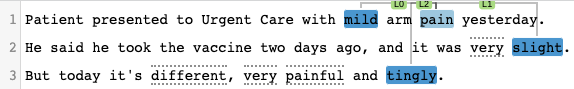

As you can see in the annotation, there are three sentences in the document. And the three relations are located in each sentences.

- L0: mild+pain: the same sentence
- L1: slight+pain: inter-sentence
- L2: tingly+pain: inter-sentence

Due the limitation of sentence-based format, the relations must be binded to a specific sentence.
So, when parsing this kind of inter-sentence relation to a sentence-based format, we need to decide the strategy of how to treat those relations.

With MedTator's toolkits, the annotated XML can be converted to sentence-based format in the following three strategies:

1. **Exclude inter-sentence relations**.  
2. **Include inter-sentence relations in the first sentence** in which the relation's entities occurs
3. **Include inter-sentence relations in all sentences** in which the relation's entities occurs.

The following sections will show how each strategy is implemented with MedTator's toolkit.

# Load data

First, let's load the XML file by `medtator_kits.py`

As shown in the following output, the XML format data is converted to an JSON format with all the details.
Then, we can convert this `ann` to sentence-based data structure by different strategies.

In [2]:
path = '../sample/ENTITY_RELATION_TASK/ann_xml/Annotator_A/A_doc5.txt.xml'
ann = mtk.parse_xml(path)
ann

{'_filename': 'A_doc5.txt.xml',
 'text': "Patient presented to Urgent Care with mild arm pain yesterday.\nHe said he took the vaccine two days ago, and it was very slight.\nBut today it's different, very painful and tingly.",
 'meta': {},
 'tags': [{'tag': 'AE',
   'spans': [[47, 51]],
   'text': 'pain',
   'id': 'A0',
   'certainty': 'positive',
   'comment': 'NA'},
  {'tag': 'SVRT',
   'spans': [[38, 42]],
   'text': 'mild',
   'id': 'S0',
   'severity': 'NA',
   'comment': 'NA'},
  {'tag': 'SVRT',
   'spans': [[121, 127]],
   'text': 'slight',
   'id': 'S1',
   'severity': 'NA',
   'comment': 'NA'},
  {'tag': 'SVRT',
   'spans': [[172, 178]],
   'text': 'tingly',
   'id': 'S2',
   'severity': 'NA',
   'comment': 'NA'},
  {'tag': 'LK_AE_SVRT',
   'id': 'L0',
   'link_AEID': 'A0',
   'link_AEText': 'pain',
   'link_SVRTID': 'S0',
   'link_SVRTText': 'mild',
   'comment': 'NA'},
  {'tag': 'LK_AE_SVRT',
   'id': 'L1',
   'link_AEID': 'A0',
   'link_AEText': 'pain',
   'link_SVRTID': 'S1

# Demos

In the `sentence_kits.py`, we provide a function `convert_ann_to_sentag()` to convert the parsed `ann` object to `ann_sent` object, which is a sentence-based format object.
For example:

```json
{
    "text": "The full text of the file",
    "sentence_tags": [{
        "sentence": "this is a sentence.",
        "sentence_tokens": ["this", "is", "a" "sentence", "."],
        "spans": [start, end],
        "entities": {
            "A1": {
                "id": "A1",
                "text": "this",
                "token_index": [0, 0]
                // other entity properties
            },
            "A2": {
                "id": "A2",
                "text": "a sentence",
                "token_index": [2, 3]
                // other entity properties
            }
        },
        "relations": {
            "R1": {
                "id": "R1",
                "link_EAID": "A1", // this
                "link_EBID": "A2", // a sentence
            }
        }
    }]
}
```

The document is splitted into sentences, which are saved as a list in the `sentence_tags`.
Each item in the `sentence_tags` contains the information about a sentence, including:

- the `sentence` itself.
- the `sentence_tokens` of the tokenized sentence.
- the `spans` in the whole text.
- the `entities` in the sentence.
- and the `relations` related to the sentence. We will change relations included in this `relations` attribute.

The raw output is a little hard to read, let's define a helper to visualize the structure easier

In [3]:
def visualize_ann_sent(ann_sent):
    '''Visualize ann_sent'''
    for sentag_idx, sentag in enumerate(ann_sent['sentence_tags']):
        ents = ', '.join(['%s[%s]'%(k, sentag['entities'][k]['text']) for k in sentag['entities']])
        rels = ', '.join(['%s'%(k) for k in sentag['relations']])
        print('*'*30)
        print('Sentence %s: %s' % (sentag_idx, sentag['sentence'].strip()))
        print(' - Entity  : %s' % ents)
        print(' - Relation: %s' % rels)
        
    print('*'*30)

## Strategy 1: Exclude inter-sentence relations

Just exclude all inter-sentence relations by adding `flag_include_partial_matched_relation=False` in the `convert_ann_to_sentag`.

As shown in the following output, only the `L0` relation is kept.
Other inter-sentence relations are removed from the output.

In [4]:
ann_sent = stk.convert_ann_to_sentag(
    ann,
    is_exclude_no_entity_sentence=False,
    flag_include_partial_matched_relation=False
)
visualize_ann_sent(ann_sent)
ann_sent

* mapping tags to sentences for A_doc5.txt.xml
* added relation [L0] to sentence [0] as all entities are in the same sentence
******************************
Sentence 0: Patient presented to Urgent Care with mild arm pain yesterday.
 - Entity  : A0[pain], S0[mild]
 - Relation: L0
******************************
Sentence 1: He said he took the vaccine two days ago, and it was very slight.
 - Entity  : S1[slight]
 - Relation: 
******************************
Sentence 2: But today it's different, very painful and tingly.
 - Entity  : S2[tingly]
 - Relation: 
******************************


{'text': "Patient presented to Urgent Care with mild arm pain yesterday.\nHe said he took the vaccine two days ago, and it was very slight.\nBut today it's different, very painful and tingly.",
 'sentence_tags': [{'sentence': 'Patient presented to Urgent Care with mild arm pain yesterday.\n',
   'sentence_tokens': ['Patient',
    'presented',
    'to',
    'Urgent',
    'Care',
    'with',
    'mild',
    'arm',
    'pain',
    'yesterday',
    '.',
    '\n'],
   'sentence_spans': [0, 63],
   'entities': {'A0': {'tag': 'AE',
     'spans': [[47, 51]],
     'text': 'pain',
     'id': 'A0',
     'certainty': 'positive',
     'comment': 'NA',
     'token_index': [8, 8]},
    'S0': {'tag': 'SVRT',
     'spans': [[38, 42]],
     'text': 'mild',
     'id': 'S0',
     'severity': 'NA',
     'comment': 'NA',
     'token_index': [6, 6]}},
   'relations': {'L0': {'tag': 'LK_AE_SVRT',
     'id': 'L0',
     'link_AEID': 'A0',
     'link_AEText': 'pain',
     'link_SVRTID': 'S0',
     'link_SVRTText

## Strategy 2: Include inter-sentence relations in the first sentence

Just exclude all inter-sentence relations by adding the following when calling `convert_ann_to_sentag()`: 

- `flag_include_partial_matched_relation=True`
- `flag_include_relation_in_first_sentence_only=True`

As shown in the following output, the `L1` and `L2` are saved in the first sentence.

In [5]:
ann_sent2 = stk.convert_ann_to_sentag(
    ann,
    is_exclude_no_entity_sentence=False,
    flag_include_partial_matched_relation=True,
    flag_include_relation_in_first_sentence_only=True
)
visualize_ann_sent(ann_sent2)
ann_sent2

* mapping tags to sentences for A_doc5.txt.xml
* added relation [L0] to sentence [0] as all entities are in the same sentence
* added relation [L1] to sentence [0] as it is first sentence partially matched entities
* added relation [L2] to sentence [0] as it is first sentence partially matched entities
* skipped relation [L1] for sentence [1] as it has been added to sentence [0]
* skipped relation [L2] for sentence [2] as it has been added to sentence [0]
******************************
Sentence 0: Patient presented to Urgent Care with mild arm pain yesterday.
 - Entity  : A0[pain], S0[mild]
 - Relation: L0, L1, L2
******************************
Sentence 1: He said he took the vaccine two days ago, and it was very slight.
 - Entity  : S1[slight]
 - Relation: 
******************************
Sentence 2: But today it's different, very painful and tingly.
 - Entity  : S2[tingly]
 - Relation: 
******************************


{'text': "Patient presented to Urgent Care with mild arm pain yesterday.\nHe said he took the vaccine two days ago, and it was very slight.\nBut today it's different, very painful and tingly.",
 'sentence_tags': [{'sentence': 'Patient presented to Urgent Care with mild arm pain yesterday.\n',
   'sentence_tokens': ['Patient',
    'presented',
    'to',
    'Urgent',
    'Care',
    'with',
    'mild',
    'arm',
    'pain',
    'yesterday',
    '.',
    '\n'],
   'sentence_spans': [0, 63],
   'entities': {'A0': {'tag': 'AE',
     'spans': [[47, 51]],
     'text': 'pain',
     'id': 'A0',
     'certainty': 'positive',
     'comment': 'NA',
     'token_index': [8, 8]},
    'S0': {'tag': 'SVRT',
     'spans': [[38, 42]],
     'text': 'mild',
     'id': 'S0',
     'severity': 'NA',
     'comment': 'NA',
     'token_index': [6, 6]}},
   'relations': {'L0': {'tag': 'LK_AE_SVRT',
     'id': 'L0',
     'link_AEID': 'A0',
     'link_AEText': 'pain',
     'link_SVRTID': 'S0',
     'link_SVRTText

## Strategy 3: Include inter-sentence relations in all sentences

Just exclude all inter-sentence relations by adding the following when calling `convert_ann_to_sentag()`: 

- `flag_include_partial_matched_relation=True`
- `flag_include_relation_in_first_sentence_only=False`

As shown in the following output, the `L1` is saved in both the first and second sentence, and the `L2` is saved in both the first and third sentence.

In [6]:
ann_sent3 = stk.convert_ann_to_sentag(
    ann,
    is_exclude_no_entity_sentence=False,
    flag_include_partial_matched_relation=True,
    flag_include_relation_in_first_sentence_only=False
)
visualize_ann_sent(ann_sent3)
ann_sent3

* mapping tags to sentences for A_doc5.txt.xml
* added relation [L0] to sentence [0] as all entities are in the same sentence
* added relation [L1] to sentence [0] as include relation in all related sentences
* added relation [L2] to sentence [0] as include relation in all related sentences
* added relation [L1] to sentence [1] as include relation in all related sentences
* added relation [L2] to sentence [2] as include relation in all related sentences
******************************
Sentence 0: Patient presented to Urgent Care with mild arm pain yesterday.
 - Entity  : A0[pain], S0[mild]
 - Relation: L0, L1, L2
******************************
Sentence 1: He said he took the vaccine two days ago, and it was very slight.
 - Entity  : S1[slight]
 - Relation: L1
******************************
Sentence 2: But today it's different, very painful and tingly.
 - Entity  : S2[tingly]
 - Relation: L2
******************************


{'text': "Patient presented to Urgent Care with mild arm pain yesterday.\nHe said he took the vaccine two days ago, and it was very slight.\nBut today it's different, very painful and tingly.",
 'sentence_tags': [{'sentence': 'Patient presented to Urgent Care with mild arm pain yesterday.\n',
   'sentence_tokens': ['Patient',
    'presented',
    'to',
    'Urgent',
    'Care',
    'with',
    'mild',
    'arm',
    'pain',
    'yesterday',
    '.',
    '\n'],
   'sentence_spans': [0, 63],
   'entities': {'A0': {'tag': 'AE',
     'spans': [[47, 51]],
     'text': 'pain',
     'id': 'A0',
     'certainty': 'positive',
     'comment': 'NA',
     'token_index': [8, 8]},
    'S0': {'tag': 'SVRT',
     'spans': [[38, 42]],
     'text': 'mild',
     'id': 'S0',
     'severity': 'NA',
     'comment': 'NA',
     'token_index': [6, 6]}},
   'relations': {'L0': {'tag': 'LK_AE_SVRT',
     'id': 'L0',
     'link_AEID': 'A0',
     'link_AEText': 'pain',
     'link_SVRTID': 'S0',
     'link_SVRTText

# Next step

Once the XML is converted to the sentence-based structure, we can further convert it to other formats.